In this notebook, we will extract features from images taken by the Atmospheric Imaging Assembly (AIA) instrument on NASA's Solar Dynamics Observatory (SDO) satellite by co-aligning them with the Helioseismic and Magnetic Imager (HMI) instrument's Space-weather HMI Active Region Patch [SHARP](https://link.springer.com/article/10.1007/s11207-014-0529-3) data. To know more about this space observatory go through [SDO](https://www.nasa.gov/mission_pages/sdo/how-sdo-sees-the-sun). The AIA instrument takes images of the Sun's atmosphere, or corona, in ultraviolet light; the HMI instrument takes images of the Sun's photosphere, or surface, in optical light. The HMI SHARP data encapsulates automatically-identified solar active regions

We install SunPy package below along with other packages. To know more about SunPy and use it further go through [SunPy](https://docs.sunpy.org/en/stable/installation.html).

In [ ]:
!pip install sunpy astropy drms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.6 MB/s eta 0:00:00


During solar flares, the Sun's corona gets particularly bright. Here's a video of one of the largest flares that erupted during 2012.

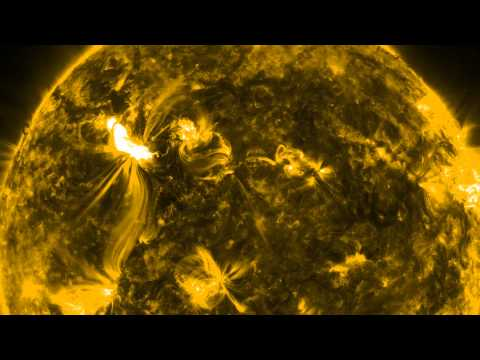

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("4xKRBkBBEP0", start=9)

We still do not fully understand why a solar flare releases so much energy so fast, and what, exactly, the magnetic topology of the corona looks like during a flare. One commonly, though not universally, accepted theory is that ropes of magnetic field, called flux ropes, hang out in the chromosphere, or the layer between the solar surface and corona. These ropes twist up and release energy during a flare. If that's true, we should look at the chromosphere for clues. Let's grab an image showing a patch of the chromosphere where the flare takes place. First, let's import some modules:

In [ ]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, requests
import sunpy.map
import drms
from astropy.io import fits
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import astropy.units as u
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime as dt_obj
import matplotlib.dates as mdates
import matplotlib.colors as mcol
import matplotlib.patches as ptc
from matplotlib.dates import *
import math

In [ ]:
import drms
c = drms.Client()

Now, let's query the [JSOC](http://jsoc.stanford.edu/) database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the AIA chromospheric image files. The first step is to establish a connection to JSOC. This can be done with the drms.Client() class. [Here is](https://docs.sunpy.org/projects/drms/en/stable/index.html) more information on how to download SDO data using the drms module.



---


We query for a few keywords. We'll need these keywords later to coalign these data with others. For the AIA data, this is what they mean:

1. T_REC indicates the time the image was taken (technically the mid-point of the integration time),
2. CROTA2 indicates the rotation of the camera with respect to the fixed Sun in degrees,
3. CDELT1n indicates the platescale of the instrument in arseconds per pixel,
4. CRPIXn indicates the the location of the center of the Sun on the CCD in pixels, and
5. CRVALn indicates the same thing as CRPIXn, but in arcseconds.

In [ ]:
query = 'aia.lev1[2012.03.06_23:29:06_TAI/12s][?WAVELNTH=1600?]'
keys_aia, segments = c.query(query, key='T_REC,CRVAL1, CRVAL2, CRPIX1, CRPIX2, CROTA2, CDELT1', seg='image_lev1')
url_aia = 'http://jsoc.stanford.edu' + segments.image_lev1[0]   # add the jsoc.stanford.edu suffix to the segment name
chromosphere_image = fits.open(url_aia)
chromosphere_header = dict(keys_aia.iloc[0])          # download the data

In [ ]:
aia = sunpy.map.Map(url_aia)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

image_lev1.fits:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

In [ ]:
aia.peek()

<sunpy.map.sources.sdo.AIAMap object at 0x7ce6f882ab30>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 1600.0 Angstrom
Wavelength:		 1600.0 Angstrom
Observation Date:	 2012-03-06 23:28:41
Exposure Time:		 2.9012 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.609112 0.609112] arcsec / pix
Reference Pixel:	 [2061.929932 2041.319946] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[ 1,  1, -1, ...,  1,  1,  0],
       [ 0, -2,  2, ..., -1, -2, -1],
       [-1,  1, -1, ...,  1, -1,  1],
       ...,
       [ 0,  0,  0, ...,  0, -1,  1],
       [-1,  2,  0, ...,  1, -1,  1],
       [ 2,  0, -1, ..., -1,  3, -2]], dtype=int16)
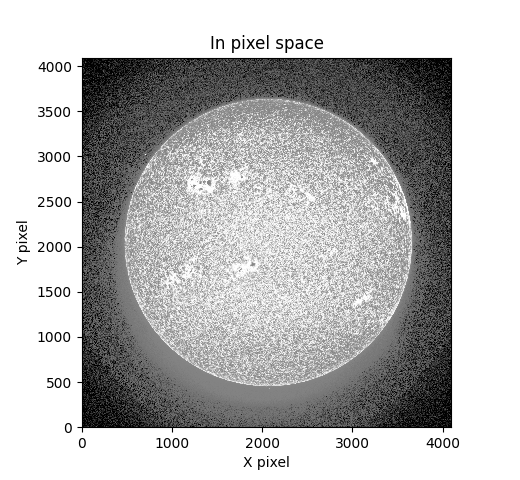
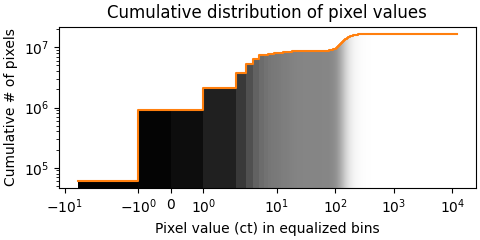

In [ ]:
aia

The Helioseismic and Magnetic Imager (HMI), another instrument aboard SDO, takes images of the solar surface, or photosphere. Here's an image of the photosphere taken at the same time as the chromospheric image above. You can see that it is rotated 180 degrees with respect to the AIA image, which is why it is important for us keep track of the CROTA2 value for each instrument into consideration when doing any array manipulation.

In [ ]:
query = 'hmi.M_720s[2012.03.06_23:29:06_TAI/12m]'
keys_hmi, segments = c.query(query, key='T_REC,CRVAL1, CRVAL2, CRPIX1, CRPIX2, CROTA2, CDELT1, CUNIT1, CUNIT2', seg='magnetogram')
url_hmi = '	http://jsoc1.stanford.edu/SUM2/D1697974726/S00000/hmi.M_720s.20120306_232400_TAI.1.magnetogram.fits'
photosphere_full_image = fits.getdata(url_hmi)                   # download the image data

In [ ]:
photosphere_full_image, hmi_header = fits.getdata(url_hmi, header=True)

In [ ]:
hmi = sunpy.map.Map(photosphere_full_image, hmi_header)

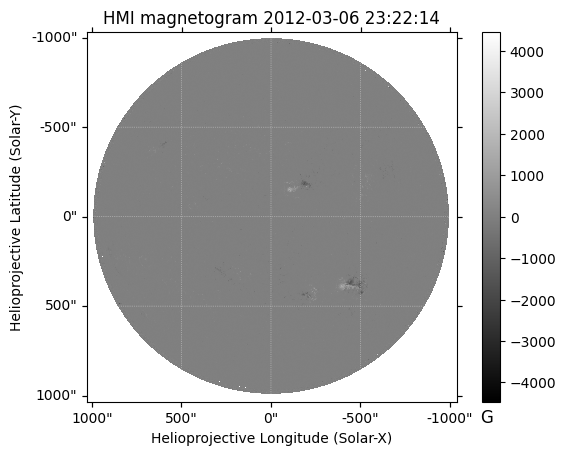

In [ ]:
hmi.peek()

<sunpy.map.sources.sdo.HMIMap object at 0x7ce6ab51a8c0>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 HMI SIDE1
Detector:		 HMI
Measurement:		 magnetogram
Wavelength:		 6173.0
Observation Date:	 2012-03-06 23:22:14
Exposure Time:		 Unknown
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.5042907 0.5042907] arcsec / pix
Reference Pixel:	 [2037.3916  2047.58521] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
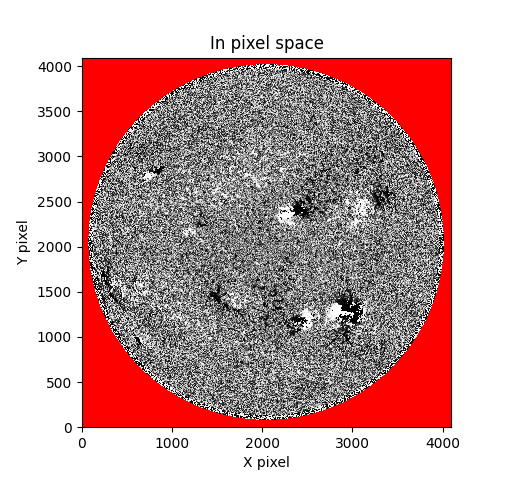
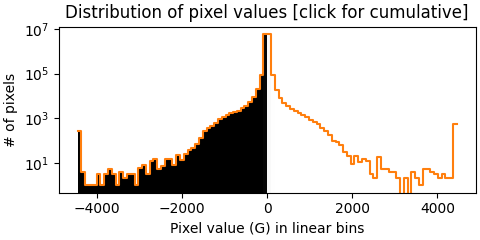
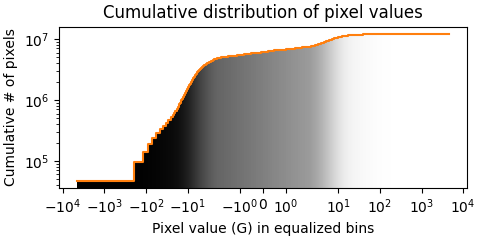

In [ ]:
hmi

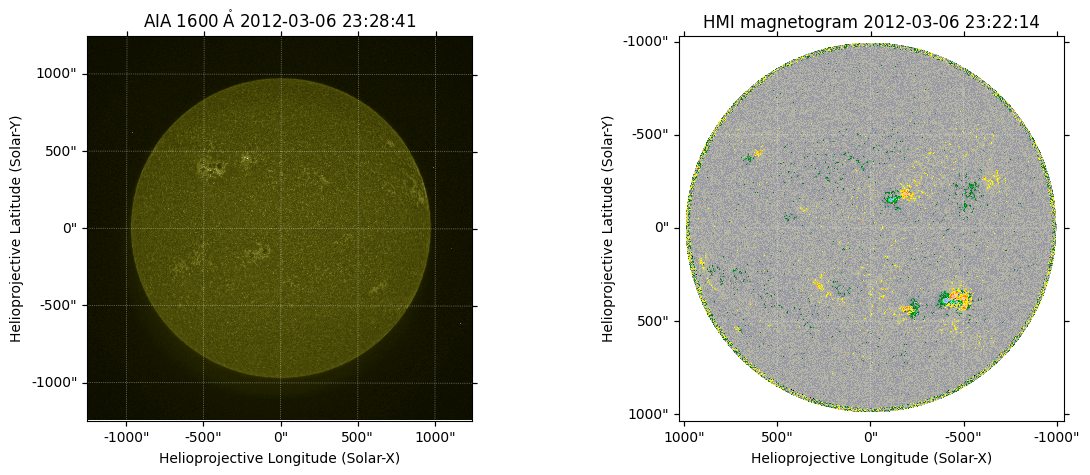

In [ ]:
hmi.plot_settings['cmap'] = "hmimag"
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121, projection=aia)
aia.plot(axes=ax1)
ax2 = fig.add_subplot(122, projection=hmi)
hmi.plot(axes=ax2)

**What do you notice comparing AIA and HMI images?**  Let's see what to do about this!

In [ ]:
new_dimensions = [1024, 1024] * u.pixel
aia_resamp = aia.resample(new_dimensions)
hmi_resamp = hmi.resample(new_dimensions)

(-0.5, 1023.5, -0.5, 1023.5)

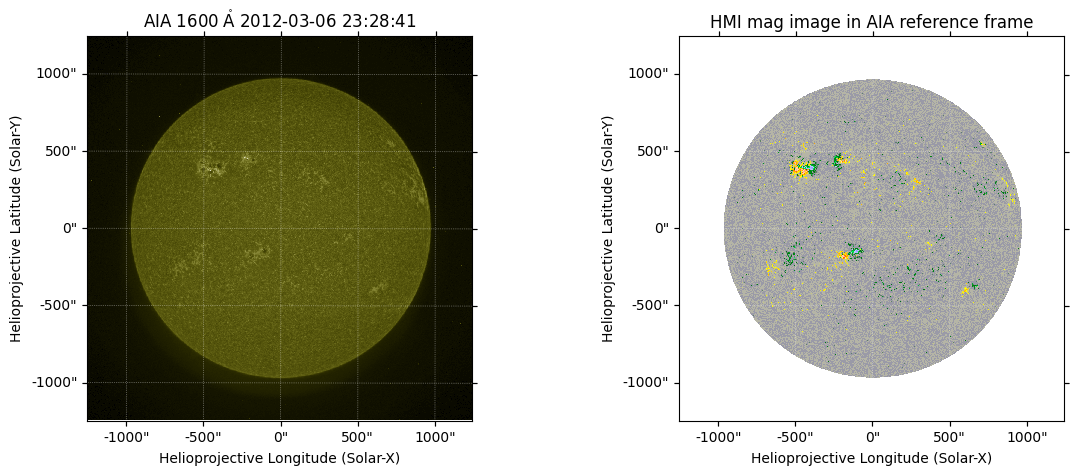

In [ ]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121, projection=aia_resamp)
aia_resamp.plot(axes=ax1)
ax2 = fig.add_subplot(122, projection=aia_resamp)
hmi_resamp.plot(axes=ax2, autoalign=True, title='HMI mag image in AIA reference frame')
ax2.axis(ax1.axis())

Setting autoalign=True allows plotting the HMI image onto axes defined by the AIA reference frame. In contrast to the above code block, we intentionally set the projection for the axes to be the AIA map instead of the HMI map. Note that the HMI image now has the same orientation as the AIA image in the above plot.

Let's zoom in on the active region. There's a particular type of SDO data called HMI Active Region Patches, or HARPs. These are bitmaps that identify automatically-detected active regions. Specifically, the bitmap array assigns a value to each pixel inside the bounding box, depending on whether it i) resides inside or outside the active region, and ii) corresponds to weak or strong line-of-sight magnetic field. This is what these patches look like for our selected T_REC.

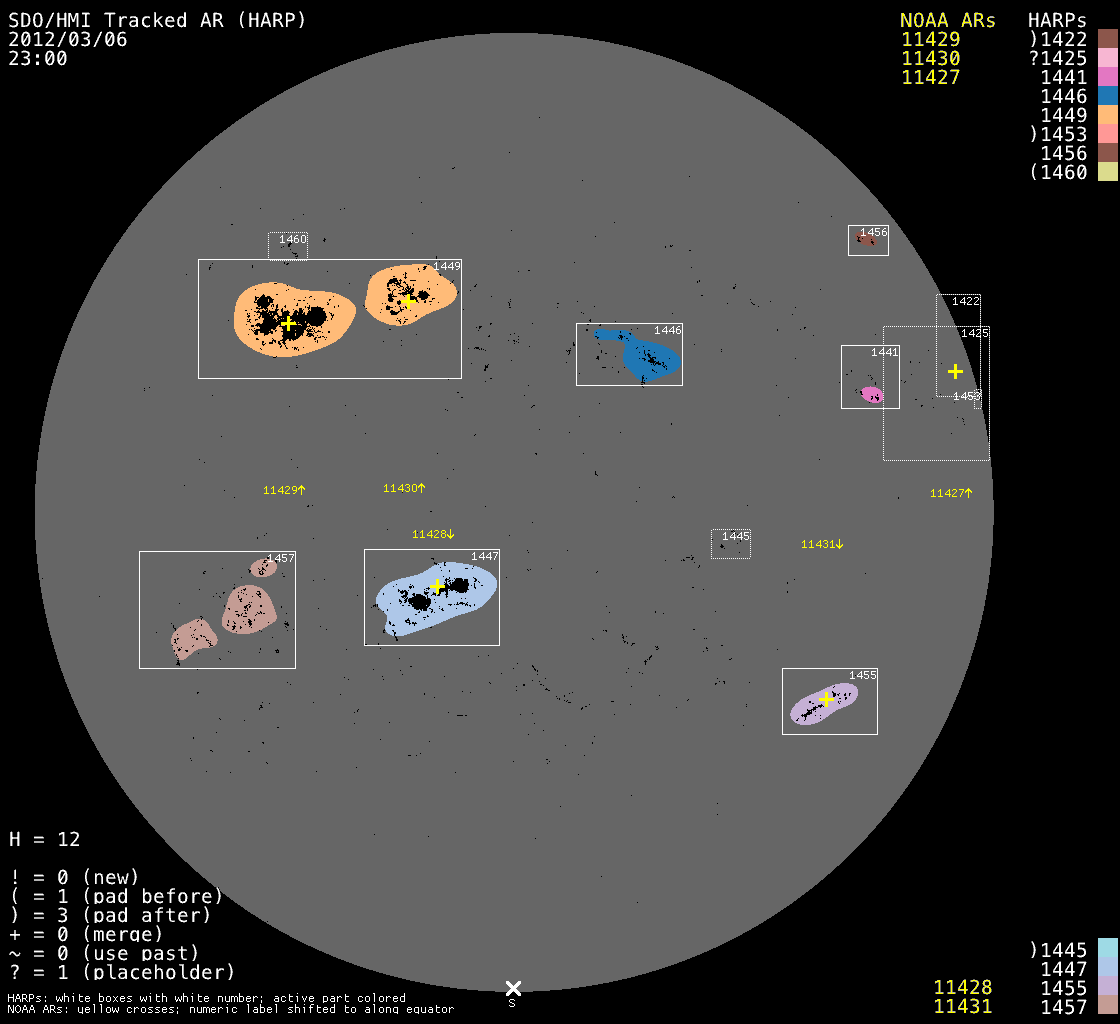

In [ ]:
from IPython.display import Image
Image("http://jsoc.stanford.edu/doc/data/hmi/harp/harp_definitive/2012/03/06/harp.2012.03.06_23:00:00_TAI.png")

We use the HARP bounding box as a stencil to cut out patches of data from full-disk images. The full-disk SDO data use the standard World Coordinate System for solar images ([Thompson, 2006](https://ui.adsabs.harvard.edu/abs/2006A%26A...449..791T/abstract)). The patch data, which we call Space-weather HMI Active Region Patches (or [SHARPs](https://link.springer.com/article/10.1007/s11207-014-0529-3)), are available in either of two coordinate systems: one is effectively cut out directly from corrected full-disk images, which are in Helioprojective Cartesian CCD image coordinates, and the other is remapped from CCD coordinates to a Carrington Heliographic Cylindrical Equal-Area (CEA) projection centered on the patch.

First, let's go through an example for HARP number 1449 for our selected T_REC for the CCD case.

First, we query for CCD-coordinate SHARP data:

In [ ]:
query = 'hmi.sharp_720s[1449][2012.03.06_23:29:06_TAI]'
keys_ccd, segments = c.query(query, key='T_REC, DATAMEAN, IMCRPIX1, IMCRPIX2, CRVAL1, CRVAL2, CRPIX1, CRPIX2, CROTA2, CDELT1', seg='magnetogram')
url_ccd = 'http://jsoc1.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
#url_ccd = 'http://jsoc1.stanford.edu/SUM66/D1697978644/S00000/hmi.sharp_720s.1449.20120306_232400_TAI.magnetogram.fits'
photosphere_image = fits.open(url_ccd)                           # download the data
XDIM_CCD = photosphere_image[1].data.shape[1]
YDIM_CCD = photosphere_image[1].data.shape[0]

In addition to downloading the patch data, we also need some metadata.

Here are the relevant keywords for the HMI SHARP Helioprojective Cartesian CCD image coordinate data (from the DRMS series hmi.sharp_720s):

1. CROTA2 indicates the rotation of the camera with respect to the fixed Sun in degrees,
2. CRVALn indicates the reference pixel coordinate at disk center,
3. IMCRPIXn indicates the location, in pixels, of disk center,
4. CRPIXn indicates the location, in pixels, of disk center with respect to the lower left-hand corner of the patch,
5. CDELTn indicates the platescale of the instrument, in arcseconds per pixel, and
6. XDIM and YDIM give the x and y-dimensions of the image, respectively, in pixels.


Now we can plot HARP number 1449 at this T_REC in CCD coordinates (using the SunPy color table for SDO images):

The dimensions of this image are 480 by 1056 pixels.


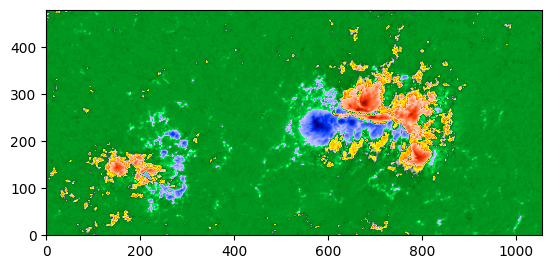

In [ ]:
hmimag = plt.get_cmap('hmimag')
plt.imshow(photosphere_image[1].data,cmap=hmimag,origin='lower')
print('The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'pixels.')

We can identify this area on the full-disk photospheric image in CCD coordinates.

First, we identify the center of the solar disk. The center of the solar disk is given by the keywords (IMCRPIX1,IMCRPIX2). The center of the Sun is not always at the center of the CCD array. In other words, the center of the Sun is not always at (2048, 2048) on the CCD.

In [ ]:
print("The center of the solar disk is at (", keys_ccd.IMCRPIX1[0],",",keys_ccd.IMCRPIX2[0],") in pixel coordinates.")

The center of the solar disk is at ( 2038.391602 , 2048.585205 ) in pixel coordinates.


Now we identify the reference coordinate at disk center, given by the keywords CRVALn.

In [ ]:
print("The center of the solar disk center is (", keys_ccd.CRVAL1[0],",",keys_ccd.CRVAL2[0],") in reference coordinates.")

The center of the solar disk center is ( 0.0 , 0.0 ) in reference coordinates.


This means we are defining a new coordinate system where (0,0) is the center of the solar disk.

Next, we identify the distance between the lower left-hand corner of the bounding box and the reference coordinate. This value is given in the keyword CRPIXn. In other words, the lower left-hand corner of the bounding box is CRPIXn away from the reference coordinate.

In [ ]:
print("The solar disk center is", keys_ccd.CRPIX1[0], "away from the lower left-hand corner of the patch in the X-direction.")
print("The solar disk center is", keys_ccd.CRPIX2[0], "away from the lower left-hand corner of the patch in the Y-direction.")

The solar disk center is -203.608398 away from the lower left-hand corner of the patch in the X-direction.
The solar disk center is 1012.585205 away from the lower left-hand corner of the patch in the Y-direction.


If the lower left-hand corner of the bounding box is CRPIXn away from the reference coordinate (IMCRPIXn), we can calculate it as follows:

In [ ]:
# lower left-hand corner
x1 = (keys_ccd.IMCRPIX1[0] - keys_ccd.CRPIX1[0])
y1 = (keys_ccd.IMCRPIX2[0] - keys_ccd.CRPIX2[0])

We can calculate the upper right-hand corner simply by adding the Y-dimension of the bounding box:

In [ ]:
# upper right-hand corner
x2 = (keys_ccd.IMCRPIX1[0] - keys_ccd.CRPIX1[0] + XDIM_CCD)
y2 = (keys_ccd.IMCRPIX2[0] - keys_ccd.CRPIX2[0] + YDIM_CCD)

We can plot the two coordinates and a bounding box connecting them:

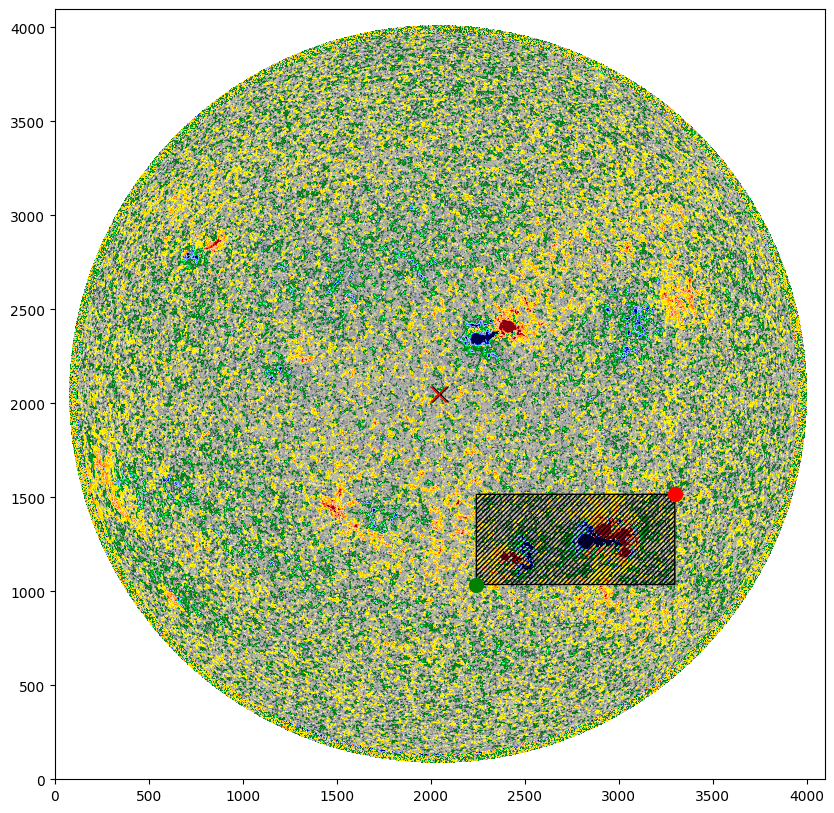

In [ ]:
fig, ax = plt.subplots(1,1)
plt.imshow(photosphere_full_image,cmap=hmimag,origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])

# draw a box using matplotlib.patches.Rectangle
ax.add_patch(ptc.Rectangle((x1, y1), XDIM_CCD, YDIM_CCD, hatch='///////', fill=False, snap=False))

# plot a black x at the center of the CCD
plt.plot(2048, 2048, marker='x', color='black', markersize=12.0)

# plot a red x at disk center
plt.plot(keys_ccd.IMCRPIX1[0], keys_ccd.IMCRPIX2[0], marker='x', color='red', markersize=12.0)

# plot a green dot at the lower left-hand corner
plt.plot(x1, y1, 'g.', markersize=20.0)

# plot a red dot at the upper right-hand corner
plt.plot(x2, y2, 'r.', markersize=20.0)

fig.set_size_inches(10,10)

Remember that in the CCD image, the angle between the HMI camera and the fixed Sun is approximately 180 (given by CROTA2). To fix this, we can rotate the image to ensure the angle is zero.

In [ ]:
if (keys_ccd.CROTA2[0] > 5.0):
    print("The HMI camera rotation angle is",keys_ccd.CROTA2[0],". Rotating HMI images.")
    photosphere_full_image = np.rot90(photosphere_full_image,2)
    photosphere_image[1].data = np.rot90(photosphere_image[1].data,2)

The HMI camera rotation angle is 180.082581 . Rotating HMI images.


The coordinates would make a similar transformation.

In [ ]:
# lower left-hand corner
x1 = (keys_ccd.IMCRPIX1[0] + keys_ccd.CRPIX1[0] - XDIM_CCD)
y1 = (keys_ccd.IMCRPIX2[0] + keys_ccd.CRPIX2[0] - YDIM_CCD)

# upper right-hand corner
x2 = (keys_ccd.IMCRPIX1[0] + keys_ccd.CRPIX1[0])
y2 = (keys_ccd.IMCRPIX2[0] + keys_ccd.CRPIX2[0])

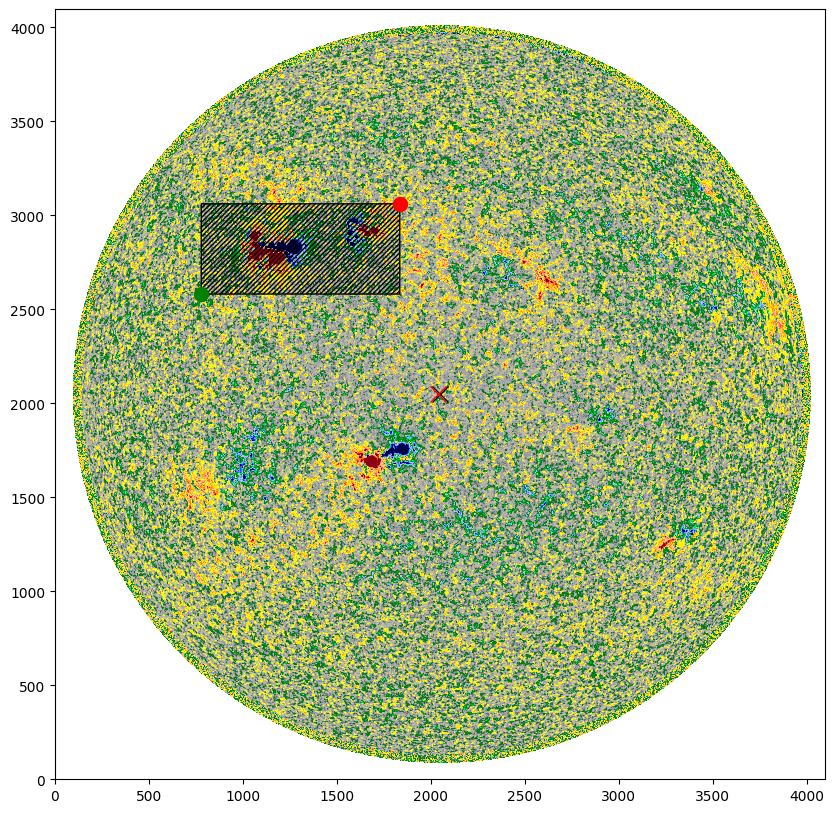

In [ ]:
fig, ax = plt.subplots(1,1)
plt.imshow(photosphere_full_image,cmap=hmimag,origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])

# draw a box using matplotlib.patches.Rectangle
ax.add_patch(ptc.Rectangle((x1, y1), XDIM_CCD, YDIM_CCD, hatch='///////', fill=False, snap=False))

# plot a black x at the center of the CCD
plt.plot(2048, 2048, marker='x', color='black', markersize=12.0)

# plot a red x at disk center
plt.plot(keys_ccd.IMCRPIX1[0], keys_ccd.IMCRPIX2[0], marker='x', color='red', markersize=12.0)

# plot a green dot at the lower left-hand corner
plt.plot(x1, y1, 'g.', markersize=20.0)

# plot a red dot at the upper right-hand corner
plt.plot(x2, y2, 'r.', markersize=20.0)

fig.set_size_inches(10,10)

Now, we'll identify which AIA pixels are included inside each of these SHARP bounding boxes.

**Identifying which AIA pixels are within the CCD-coordinate SHARP bounding box**

If we are interested in cutting a SHARP-sized box out of AIA data, the first thing we can do is compute the ratio of the platescales. Since HMI and AIA are not observing in the same wavelength, the radius of the solar disk is different in both images and, as a result, the platescale is too:

In [ ]:
ratio = (keys_ccd.CDELT1[0])/(keys_aia.CDELT1[0])
print("The ratio of the HMI:AIA platescales is",ratio,".")

The ratio of the HMI:AIA platescales is 0.8275571776235573 .


Now we can cut the same sized array out of the AIA data. We must make sure that the angle between the camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so.

In [ ]:
if (keys_aia.CROTA2[0] > 5.0):
    print("The AIA camera rotation angle is",keys_aia.CROTA2[0],". Rotating AIA image.")
    chromosphere_image[1].data = np.rot90(chromosphere_image[1].data,2)

In [ ]:
delta_disk_center_x = (2048.-keys_hmi.CRPIX1)
delta_disk_center_y = (2048.-keys_hmi.CRPIX2)

In [ ]:
y1 = int(2048. + delta_disk_center_y*(ratio) + keys_ccd.CRPIX2[0]*(ratio) - YDIM_CCD*(ratio))
y2 = int(2048. + delta_disk_center_y*(ratio) + keys_ccd.CRPIX2[0]*(ratio))
x1 = int(2048. + delta_disk_center_x*(ratio) + keys_ccd.CRPIX1[0]*(ratio) - XDIM_CCD*(ratio))
x2 = int(2048. + delta_disk_center_x*(ratio) + keys_ccd.CRPIX1[0]*(ratio))

In [ ]:
subdata = chromosphere_image[1].data[y1:y2, x1:x2]

Now we can look at the patch of chromospheric data taken by the AIA instrument. Though it is not easy to see, the twisted S-shape feature may be the signature of a flux rope.

The dimensions of this image are 397 by 874 pixels.


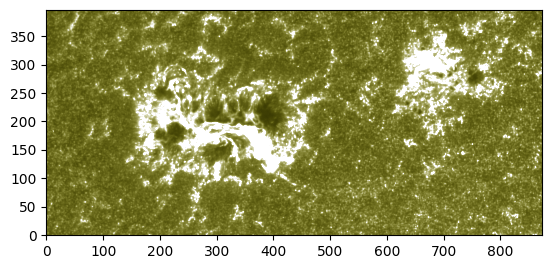

In [ ]:
sdoaia1600 = plt.get_cmap('sdoaia1600')
plt.imshow(subdata,cmap=sdoaia1600,origin='lower',vmin=0,vmax=400)
print('The dimensions of this image are',subdata.shape[0],'by',subdata.shape[1],'pixels.')


You can see the chromospheric patch is a bit smaller, in both latitudinal and longitudinal extent, from the photospheric data taken by the HMI instrument. This is exactly what we expect since the solar radius is a bit smaller in the ultraviolet wavelengths taken by AIA versus the optical wavelengths observed by HMI.

Identifying which AIA pixels are within the CEA-coordinate SHARP bounding box

Now we can go through the same exercise for CEA-coordinate SHARP data. The CEA data are useful for two reasons:

1. Each pixel is of an equal area, so derivatives or other such numerical computations are straightforward, and
2. The space-weather keywords included in the SHARP metadata, which characterize the photospheric vector magnetic field, are computed using the CEA data; as such, computing a feature using a CEA-sized cutout of the AIA data allows for easy comparison between the space-weather keywords and any feature derived from the AIA data.


Here are the relevant keywords mean in the Carrington Heliographic Cylindrical Equal-Area coordinate system:

1. CRLT_OBS indicates the Carrington latitude of the observer in degrees,
2. CDELTn indicates the platescale of the image in degrees per pixel, which, per the definition of equal-area, is always constant (0.03 degrees per pixel),
3. CRVALn indicates the longitude and latitude at the center of the patch, in degrees,
4. CRLN_OBS indicates the Carrington longitude of the observer in degrees, and
5. XDIM and YDIM give the x and y-dimensions of the image, respectively, in pixels.

In [ ]:
query = 'hmi.sharp_cea_720s[1449][2012.03.06_23:29:06_TAI]'
keys_cea, segments = c.query(query, key='T_REC, DATAMEAN, IMCRPIX1, IMCRPIX2, CRVAL1, CRVAL2, CRPIX1, CRPIX2, CROTA2, CDELT1, CTYPE1, CTYPE2', seg='magnetogram')
#url_cea = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
url_cea = 'http://jsoc1.stanford.edu/SUM8/D1698004905/S00000/hmi.sharp_cea_720s.1449.20120306_232400_TAI.magnetogram.fits'
#url_cea = 'http://jsoc1.stanford.edu/SUM14/D1698012772/S00000/hmi.sharp_cea_720s.1447.20120306_232400_TAI.magnetogram.fits'
cea_image = fits.open(url_cea)                           # download the data
header = dict(keys_cea.iloc[0])
XDIM_CEA = cea_image[1].data.shape[1]
YDIM_CEA = cea_image[1].data.shape[0]

In [ ]:
hmi_map = sunpy.map.Map((url_cea))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

hmi.sharp_cea_720s.1449.20120306_232400_TAI.magnetogram.fits:   0%|          | 0.00/605k [00:00<?, ?B/s]

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


In [ ]:
plt.imshow(cea_image[1].data,cmap=hmimag,origin='lower')
print('The dimensions of this CEA-projected image are',cea_image[1].data.shape[0],'by',cea_image[1].data.shape[1],'pixels.')

The dimensions of this CEA-projected image are 460 by 1167 pixels.


And this is what the SHARP data look like in Carrington Heliographic coordinates, with a yellow X marking the center of the image.

In [ ]:
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(2,1,1, projection=hmi_map)
hmi_map.plot(cmap=hmimag)
ax.set_title('HMI SHARP at '+str(keys_cea.T_REC[0]))

# Define the spatial center of HMI patch in latitude and longitude
xc = keys_cea.CRVAL1[0]*u.deg
yc = keys_cea.CRVAL2[0]*u.deg
coords = SkyCoord(xc, yc, frame=hmi_map.coordinate_frame)
p = ax.plot_coord(coords, 'x', color='yellow', markersize=16)

To map the CEA data to the AIA data, we follow the steps outlined in [Sun et al. (2014)](http://arxiv.org/pdf/1309.2392v1.pdf). First, we use the SunPy coordinates module to convert the latitude and longitude at the center of the patch from the Heliographic Carrington coordinate system, which has units of degrees, to Helioprojective Cartesian coordinates, which has units of arcseconds. Second, we use the AIA platescale to convert arcseconds to AIA pixels.

Because the CEA data is projected, the bounding box is not a rectangular shape in CCD coordinates. Thus we will identify which AIA pixels lie within the CEA bounding box by using a mask.

First, populate the mask with NaNs:

In [ ]:
aia_mask = np.full([4096,4096], np.nan)

Create a Skycoord object in Heliographic Carrington coordinates for all the points in the CEA box:

In [ ]:
x_coord_single = [(keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0] + i*keys_cea.CDELT1[0]) for i in range(int(XDIM_CEA))]
y_coord_single = [(keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0] + j*keys_cea.CDELT1[0]) for j in range(int(YDIM_CEA))]

In [ ]:
# Create pairs of (x, y) coordinates
x_coord_pair = []
y_coord_pair = []
for j in range(len(y_coord_single)):
    for i in range(len(x_coord_single)):
        y_coord_pair.append(y_coord_single[j])
        x_coord_pair.append(x_coord_single[i])

In [ ]:
frame_coord_hg = SkyCoord(x_coord_pair*u.deg, y_coord_pair*u.deg, frame=hmi_map.coordinate_frame)

Convert all the points in the CEA box from Heliographic Carrington to Helioprojective Cartesian coordinates:

In [ ]:
HPC_out = frame_coord_hg.transform_to(frame="helioprojective")

Create a mask that identifies all the points in the CEA box on the AIA image:

In [ ]:
x_aia = ((HPC_out.Tx.value/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]).astype(int)
y_aia = ((HPC_out.Ty.value/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]).astype(int)

In [ ]:
aia_mask[y_aia,x_aia] = 1.0

This is what the mask looks like:

In [ ]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_mask,origin='lower',vmin=0,vmax=1.0,cmap='seismic',extent=[0,4096,0,4096])
fig.set_size_inches(8,8)

And this is what the masked AIA image looks like:

In [ ]:
aia_masked_data = chromosphere_image[1].data*aia_mask

In [ ]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_masked_data,origin='lower',vmin=0,vmax=400.0,cmap=sdoaia1600,extent=[0,4096,0,4096])
fig.set_size_inches(8,8)

Here's a closeup:

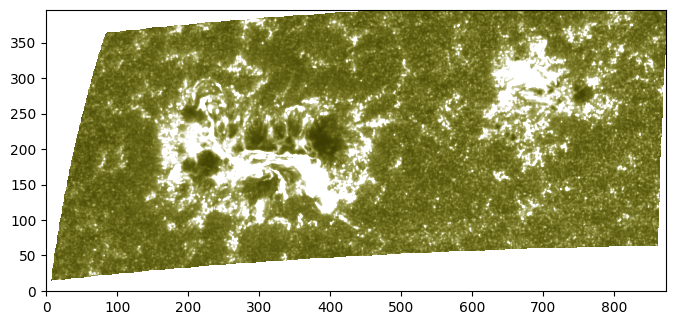

In [ ]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_masked_data[int(y1):int(y2),int(x1):int(x2)],origin='lower',vmin=0,vmax=400.0,cmap=sdoaia1600)
fig.set_size_inches(8,8)

The SHARP data also contain 18 FITS header keywords that parameterize the vector magnetic field within the strong field regions. These parameterizations include measurements of physical quantities, such as the magnetic flux;  Between 2010 May 1 and 2015 May 1, the HMI data processing pipeline automatically detected 3023 strong field regions and computed 18 parameterizations of each region at every 720-second interval throughout its lifetime, resulting in 36 million unique data points.

The query below retrieves both metadata and image data for active region 11367, which produced an X5.4-class flare on [March 06, 2012](https://svs.gsfc.nasa.gov/10925/#:~:text=The%20sun%20erupted%20with%20one,largest%20flare%20%E2%80%94%20after%20an%20X6.), from the SHARP data series. The SHARP data series include patches of vector magnetic field data taken by the HMI instrument. These patches encapsulate automatically-detected active regions that are tracked throughout the entirety of their disk passage. The c.query() method takes three arguments:

The first argument is the data series. In the example below, the data series is called hmi.sharp_cea_720s. This series is appended with two prime keys: the HARP number (in this case, 1149) and the time range (in this case, 2012.03.06_23:00:00/12h). These two prime keys appear in the first two brackets. The HARP number refers to the active region number (see [here](http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt) for a mapping between HARP numbers and NOAA active region numbers). A prime key, or set of prime keys, is a unique identifier.
The second argument in the search query is a list of keywords. In this example, we will query for the keywords T_REC, USFLUX, and ERRVF.
The third argument in the search query is a list of segments. In this example, we will query for the segment Br, or the radial component of the photospheric magnetic field.

In [ ]:
keys, segments = c.query('hmi.sharp_cea_720s[1449][2012.03.03_23:00:00/24h]', key='T_REC, USFLUX, ERRVF', seg='Br')
#keys, segments = c.query('hmi.sharp_cea_720s[377][2011.02.14_15:00:00/12h][? (QUALITY<65536) ?]', key='T_REC, USFLUX, ERRVF', seg='Br')

To convert the keyword T_REC into a datetime object, we can use the function below.

In [ ]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [ ]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

Now for some plotting! matplotlib.pyplot generates two objects: a figure and axes. The data are ascribed to the axes. The time axes in particular requires some formatting; in order to free it of clutter, we'll plot tick marks every three hours and label them accordingly.

Text(0.5, 1.0, 'total unsigned flux starting at 2012-03-03 23:00:00 UT')

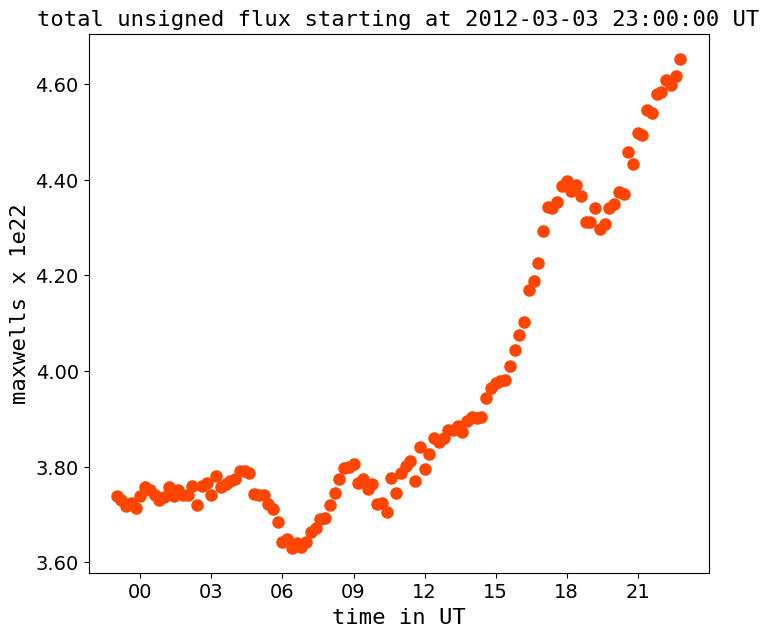

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# ascribe the data to the axes
ax.plot(t_rec, (keys.USFLUX)/(1e22),'o',**marker_style)
ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='',color=orangered)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [3] # only show every 3 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set yrange
#ax.set_ylim([5.5,5.75])

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('maxwells x 1e22',**text_style)
ax.set_title('total unsigned flux starting at '+str(t_rec[0])+' UT',**text_style) # annotate the plot with a start time

In [ ]:
c.series(r'hmi\.sharp_')

['hmi.sharp_720s',
 'hmi.sharp_720s_dconS',
 'hmi.sharp_720s_nrt',
 'hmi.sharp_cea_720s',
 'hmi.sharp_cea_720s_dconS',
 'hmi.sharp_cea_720s_nrt']

In [ ]:
# Set a series
si = c.info('hmi.sharp_cea_720s')

To find more information about the FITS header keywords that belong to any given series, we can use the following command:

In [ ]:
si.keywords

type  recscope         defval  \
name                                                  
cparms_sg000        string  variable  compress Rice   
magnetogram_bzero   double  variable              0   
magnetogram_bscale  double  variable            0.1   
cparms_sg001        string  variable                  
bitmap_bzero        double  variable              0   
...                    ...       ...            ...   
ERRMSHA              float  variable            nan   
ERRUSI               float  variable            nan   
DOFFSET                int  variable    -2147483648   
ERRTPOT              float  variable            nan   
ERRJHT               float  variable            nan   

                                        units  \
name                                            
cparms_sg000                             none   
magnetogram_bzero                        none   
magnetogram_bscale                       none   
cparms_sg001                             none   
bitmap_bzero                             none   
...                                       ...   
ERRMSHA                               Degrees   
ERRUSI                                Amperes   
DOFFSET                                 Gauss   
ERRTPOT             Ergs per cubic centimeter   
ERRJHT                                Amperes   

                                                                 note  \
name                                                                    
cparms_sg000                                                            
magnetogram_bzero                                                       
magnetogram_bscale                                                      
cparms_sg001                                                            
bitmap_bzero                                                            
...                                                               ...   
ERRMSHA                         Error in Mean shear angle for B_total   
ERRUSI                       Error in Total unsigned vertical current   
DOFFSET             Constant value added to the noise mask for dis...   
ERRTPOT             Error in Total photospheric magnetic energy de...   
ERRJHT              Sum of the Absolute Value of the Net Currents ...   

                   linkinfo  is_time  is_integer  is_real  is_numeric  
name                                                                   
cparms_sg000           None    False       False    False       False  
magnetogram_bzero      None    False       False     True        True  
magnetogram_bscale     None    False       False     True        True  
cparms_sg001           None    False       False    False       False  
bitmap_bzero           None    False       False     True        True  
...                     ...      ...         ...      ...         ...  
ERRMSHA                None    False       False     True        True  
ERRUSI                 None    False       False     True        True  
DOFFSET                None    False        True    False        True  
ERRTPOT                None    False       False     True        True  
ERRJHT                 None    False       False     True        True  

[215 rows x 10 columns]

To find more information about the FITS image data, or segments, that belong to any given series, we can use the following command:

In [ ]:
# To see all the segments associated with the series hmi.sharp_cea_720s:
si.segments

type       units protocol     dims  \
name                                                
magnetogram     int       Gauss     fits  VARxVAR   
bitmap         char  Enumerated     fits  VARxVAR   
Dopplergram     int         m/s     fits  VARxVAR   
continuum       int        DN/s     fits  VARxVAR   
Bp              int       Gauss     fits  VARxVAR   
Bt              int       Gauss     fits  VARxVAR   
Br              int       Gauss     fits  VARxVAR   
Bp_err          int       Gauss     fits  VARxVAR   
Bt_err          int       Gauss     fits  VARxVAR   
Br_err          int       Gauss     fits  VARxVAR   
conf_disambig  char        none     fits  VARxVAR   

                                                      note  
name                                                        
magnetogram    Line-of-sight magnetogram in CEA projection  
bitmap               Mask for the patch in CEA coordinates  
Dopplergram                  Dopplergram in CEA projection  
continuum                  Intensitygram in CEA projection  
Bp                                B_phi, positive westward  
Bt                             B_theta, positive southward  
Br                                        B_r, positive up  
Bp_err                         Standard deviation of B_phi  
Bt_err                       Standard deviation of B_theta  
Br_err                           Standard deviation of B_r  
conf_disambig          confidence of disambiguation result

Excercise:
1. Check and plot the field strength versus time plot for the next big sunspot seen in the HARP image already loaded.
2. Check (google query) for recent highest energy flare produced and load corresponding HARP data and check the magnetic fields in the flaring regions.

**Querying the data**

The example above shows a simple query for 12 hours of data from one HARPNUM. But we can also perform more complex queries to identify active regions of interest. Here are a few examples.

**Example 1.** Suppose we want to create a magnetic field model of an active region and we need observations of a strong-field active region near disk center. This query identifies strong-field regions near disk center during a two year period. We define strong active regions as those with a total unsigned flux (USFLUX) greater than 4$\times10^{22}$ Mx and near disk center as those with a Carrington Longitude (CRLN_OBS) less than 1∘1∘. The two year period spans between January 2014 and January 2016.

In [ ]:
keys = c.query('hmi.sharp_cea_720s[][2014.01.01 - 2016.01.01][? (CRLN_OBS < 1) AND (USFLUX > 4e22) ?]', key='T_REC, HARPNUM, USFLUX, CRLT_OBS, CRLN_OBS, AREA_ACR')

In [ ]:
keys

T_REC  HARPNUM        USFLUX  CRLT_OBS  CRLN_OBS  \
0   2014.05.04_14:48:00_TAI     4071  4.007906e+22 -3.818258  0.045204   
1   2014.11.11_06:00:00_TAI     4800  4.004017e+22  3.297165  0.676486   
2   2014.11.11_06:12:00_TAI     4800  4.023450e+22  3.295724  0.567313   
3   2014.11.11_06:24:00_TAI     4800  4.050183e+22  3.294308  0.458156   
4   2014.11.11_06:36:00_TAI     4800  4.070347e+22  3.292919  0.349014   
5   2014.11.11_06:48:00_TAI     4800  4.081056e+22  3.291558  0.239885   
6   2014.11.11_07:00:00_TAI     4800  4.094752e+22  3.290226  0.130767   
7   2014.11.11_07:12:00_TAI     4800  4.113331e+22  3.288925  0.021658   
8   2015.02.01_05:00:00_TAI     5127  4.801844e+22 -6.020030  0.985052   
9   2015.02.01_05:12:00_TAI     5127  4.817782e+22 -6.020372  0.875986   
10  2015.02.01_05:24:00_TAI     5127  4.778004e+22 -6.020685  0.766931   
11  2015.02.01_05:36:00_TAI     5127  4.801163e+22 -6.020968  0.657885   
12  2015.02.01_05:48:00_TAI     5127  4.780960e+22 -6.021223  0.548846   
13  2015.02.01_06:00:00_TAI     5127  4.724961e+22 -6.021451  0.439813   
14  2015.02.01_06:12:00_TAI     5127  4.682469e+22 -6.021652  0.330784   
15  2015.02.01_06:24:00_TAI     5127  4.597347e+22 -6.021828  0.221756   
16  2015.02.01_06:36:00_TAI     5127  4.505237e+22 -6.021980  0.112728   
17  2015.02.01_06:48:00_TAI     5127  4.448969e+22 -6.022110  0.003698   
18  2015.06.17_13:48:00_TAI     5692  4.593700e+22  1.266837  0.923733   
19  2015.06.17_14:00:00_TAI     5692  4.592959e+22  1.267220  0.813259   
20  2015.06.17_14:12:00_TAI     5692  4.593827e+22  1.267613  0.702742   
21  2015.06.17_14:24:00_TAI     5692  4.584389e+22  1.268017  0.592184   
22  2015.06.17_14:36:00_TAI     5692  4.636860e+22  1.268434  0.481585   
23  2015.06.17_14:48:00_TAI     5692  4.616645e+22  1.268866  0.370945   
24  2015.06.17_15:00:00_TAI     5692  4.629078e+22  1.269314  0.260266   
25  2015.06.17_15:12:00_TAI     5692  4.652655e+22  1.269780  0.149549   
26  2015.06.17_15:24:00_TAI     5692  4.681429e+22  1.270264  0.038794   
27  2015.10.31_19:12:00_TAI     6063  5.331063e+22  4.459106  0.909237   
28  2015.10.31_19:24:00_TAI     6063  5.314220e+22  4.458659  0.798615   
29  2015.10.31_19:36:00_TAI     6063  5.258935e+22  4.458181  0.687989   
30  2015.10.31_19:48:00_TAI     6063  5.197402e+22  4.457672  0.577359   
31  2015.10.31_20:00:00_TAI     6063  5.231150e+22  4.457130  0.466728   
32  2015.10.31_20:12:00_TAI     6063  5.238996e+22  4.456556  0.356098   
33  2015.10.31_20:24:00_TAI     6063  5.218206e+22  4.455947  0.245472   
34  2015.10.31_20:36:00_TAI     6063  5.241477e+22  4.455305  0.134850   
35  2015.10.31_20:48:00_TAI     6063  5.301954e+22  4.454628  0.024236   

       AREA_ACR  
0   1297.351685  
1   1207.938232  
2   1194.579590  
3   1198.369873  
4   1204.132935  
5   1208.038818  
6   1199.290039  
7   1222.337891  
8   2273.071289  
9   2271.228516  
10  2270.977295  
11  2278.230469  
12  2281.161621  
13  2275.408203  
14  2282.527344  
15  2280.517334  
16  2281.434570  
17  2298.415039  
18  1495.361328  
19  1503.894775  
20  1489.501465  
21  1494.039429  
22  1491.178833  
23  1495.119507  
24  1505.565796  
25  1496.576538  
26  1479.642456  
27  1804.466309  
28  1805.412476  
29  1811.795410  
30  1807.541748  
31  1802.004395  
32  1813.600952  
33  1822.455444  
34  1833.126953  
35  1834.722900

**Example 2.** Suppose we are doing a study on flux emergence and we want to identify active regions that live for a long time. This query identifies long-lived active regions within a six year period. We define long-lived active regions as those with a minimum number of observations (N_PATCH1) equal to 1800 (1800 observations with a 12 minute gap between observations means a minimum observation time of 15 days). The six year period spans between January 2012 and January 2018. The T_FRST1=T_REC clause identifies the first observation time in the sequence.

In [ ]:
keys = c.query('hmi.sharp_cea_720s[][2012.01.01 - 2018.01.01][? (N_PATCH1 > 1800) AND (T_FRST1=T_REC) ?]', key='T_REC, HARPNUM, NOAA_ARS, N_PATCH1, AREA_ACR')

In [ ]:
keys

T_REC  HARPNUM                             NOAA_ARS  \
0   2012.07.04_03:24:00_TAI     1834                    11519,11520,11521   
1   2012.07.22_21:12:00_TAI     1879        11529,11530,11532,11533,11536   
2   2012.07.30_22:24:00_TAI     1907  11538,11539,11540,11541,11544,11545   
3   2012.09.17_23:24:00_TAI     2040                    11575,11577,11583   
4   2013.04.26_15:36:00_TAI     2696                          11732,11734   
5   2013.06.12_17:24:00_TAI     2852  11769,11770,11771,11772,11774,11775   
6   2013.12.30_21:00:00_TAI     3563                          11943,11944   
7   2014.01.17_09:00:00_TAI     3647        11958,11959,11960,11963,11964   
8   2014.02.21_04:36:00_TAI     3784        11987,11989,11993,11994,12001   
9   2014.03.14_21:24:00_TAI     3856  12008,12010,12012,12015,12019,12023   
10  2014.04.10_23:00:00_TAI     4000              12035,12038,12043,12046   
11  2014.07.27_01:00:00_TAI     4396        12127,12128,12130,12131,12132   
12  2014.12.09_05:12:00_TAI     4920              12235,12237,12238,12242   

    N_PATCH1    AREA_ACR  
0       1820   28.082201  
1       1883   24.621628  
2       1809   18.218309  
3       1986  124.659348  
4       1846   18.187544  
5       1864    3.143462  
6       1822    2.208999  
7       1813   18.883802  
8       2018   30.495930  
9       1838   21.218081  
10      1878   14.411080  
11      1927   18.025908  
12      1841   21.272736